In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.utils.data import generate_data
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import StandardScaler


In [2]:
# Generate synthetic data
contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points
X_train, X_test, y_train, y_test = generate_data(n_train=n_train, n_test=n_test, n_features=2, contamination=contamination, random_state=42)


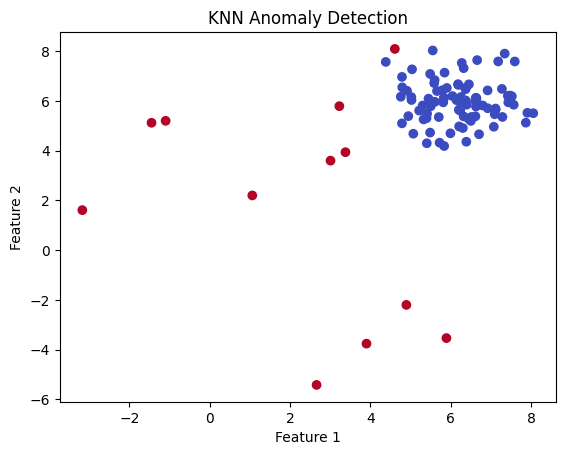

In [3]:
# Train KNN detector
clf = KNN()
clf.fit(X_train)

# Get the prediction labels and outlier scores for the test data
y_test_pred = clf.predict(X_test)  # binary labels (0: inliers, 1: outliers)
y_test_scores = clf.decision_function(X_test)  # raw outlier scores

# Plot the results
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred, cmap='coolwarm')
plt.title('KNN Anomaly Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Training: 100%|██████████| 100/100 [00:00<00:00, 122.53it/s]


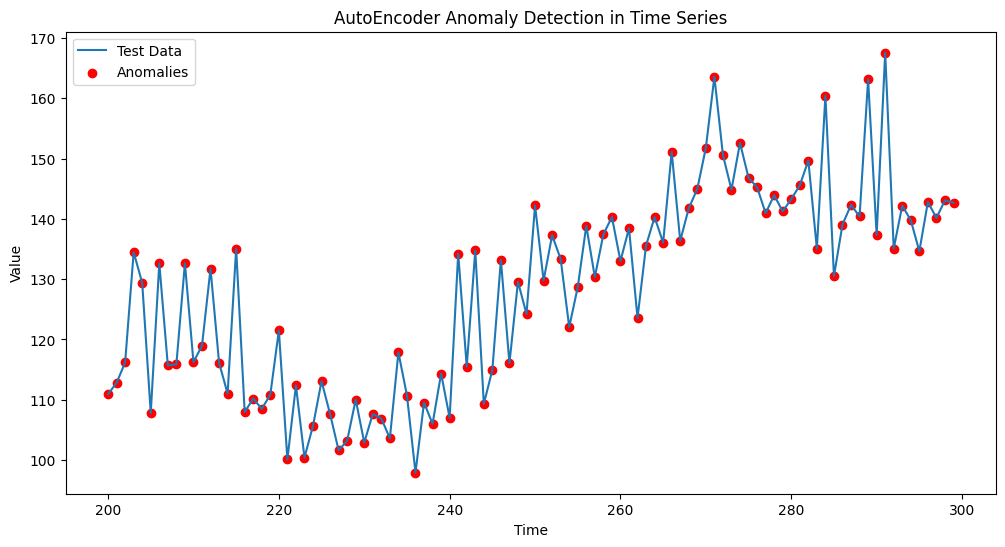

In [3]:

# Generate synthetic time series data
np.random.seed(42)
time_series_length = 300
contamination = 0.1  # percentage of outliers

# Create a time series with a trend and some noise
time = np.arange(time_series_length)
series = 0.5 * time + 10 * np.sin(0.1 * time) + np.random.normal(0, 5, time_series_length)

# Introduce anomalies
n_anomalies = int(contamination * time_series_length)
anomaly_indices = np.random.choice(time_series_length, n_anomalies, replace=False)
series[anomaly_indices] += np.random.normal(20, 5, n_anomalies)

# Reshape the data for the AutoEncoder
X = series.reshape(-1, 1)

# Split the data into training and testing sets
n_train = 200
X_train, X_test = X[:n_train], X[n_train:]

# Train the AutoEncoder detector
clf = AutoEncoder(hidden_neuron_list=[64,32,64], epoch_num=100, contamination=contamination)

clf.fit(X_train)

# Get the prediction labels and outlier scores for the test data
y_test_pred = clf.predict(X_test)  # binary labels (0: inliers, 1: outliers)
y_test_scores = clf.decision_function(X_test)  # raw outlier scores

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time[n_train:], X_test, label='Test Data')
plt.scatter(time[n_train:][y_test_pred == 1], X_test[y_test_pred == 1], color='red', label='Anomalies')
plt.title('AutoEncoder Anomaly Detection in Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Training: 100%|██████████| 200/200 [00:45<00:00,  4.40it/s]


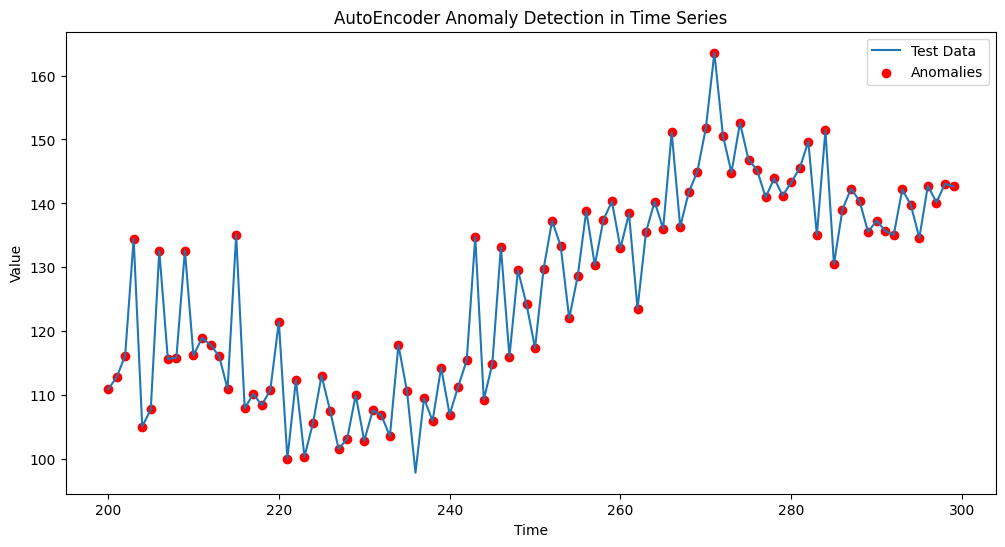

In [20]:
# Generate synthetic time series data
np.random.seed(42)
time_series_length = 300
contamination = 0.05  # Lower percentage of outliers

# Create a time series with a trend and some noise
time = np.arange(time_series_length)
series = 0.5 * time + 10 * np.sin(0.1 * time) + np.random.normal(0, 5, time_series_length)

# Introduce anomalies
n_anomalies = int(contamination * time_series_length)
anomaly_indices = np.random.choice(time_series_length, n_anomalies, replace=False)
series[anomaly_indices] += np.random.normal(20, 5, n_anomalies)

# Reshape the data for the AutoEncoder
X = series.reshape(-1, 1)

# Split the data into training and testing sets
n_train = 200
X_train, X_test = X[:n_train], X[n_train:]

# Train the AutoEncoder detector
clf = AutoEncoder(hidden_neuron_list=[128,64,32,64,34,16,8],
                 epoch_num=200,
                 contamination=contamination,
                 batch_size=16,
                 dropout_rate=0.5,
                 device="mps")
clf.fit(X_train)

# Get the prediction labels and outlier scores for the test data
y_test_pred = clf.predict(X_test)  # binary labels (0: inliers, 1: outliers)
y_test_scores = clf.decision_function(X_test)  # raw outlier scores

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time[n_train:], X_test, label='Test Data')
plt.scatter(time[n_train:][y_test_pred == 1], X_test[y_test_pred == 1], color='red', label='Anomalies')
plt.title('AutoEncoder Anomaly Detection in Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_neuron_list': [[64, 32], [128, 64, 32], [128, 64, 32, 64, 34, 16, 8]],
    'epochs': [50, 100, 200],
    'batch_size': [16, 32],
    'dropout_rate': [0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(estimator=AutoEncoder(contamination=0.05), param_grid=param_grid, scoring='f1', cv=3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_


NameError: name 'y_train' is not defined

/var/folders/wr/rq4bfhkj6h56q645ftw89wtm0000gn/T/ipykernel_76494/2516255734.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.DataFrame({'timestamp': pd.date_range(start='2023-01-01', periods=n_samples, freq='H'),
Training: 100%|██████████| 100/100 [00:05<00:00, 19.02it/s]


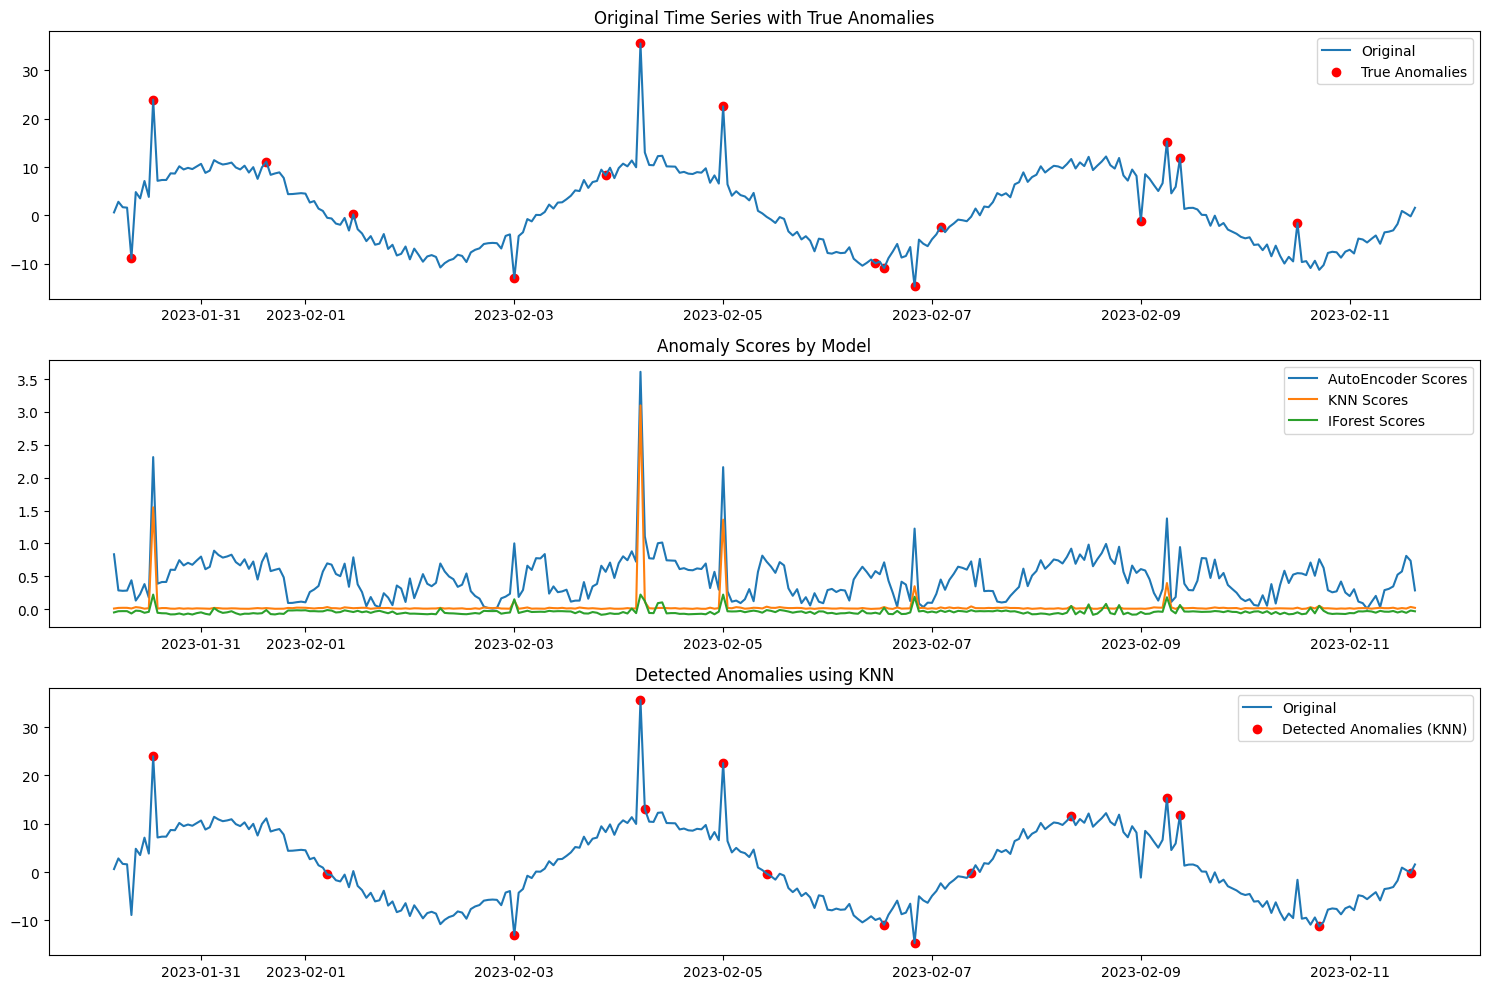

Performance Metrics:
AutoEncoder: Precision = 0.55, Recall = 0.38, F1 = 0.44
KNN: Precision = 0.54, Recall = 0.44, F1 = 0.48
IForest: Precision = 0.40, Recall = 0.50, F1 = 0.44


In [5]:
# Generate a more complex synthetic time series
def generate_complex_timeseries(n_samples=1000, contamination=0.05):
    np.random.seed(42)
    t = np.linspace(0, 10, n_samples)
    trend = 0.1 * t
    seasonality = 10 * np.sin(2 * np.pi * t)
    noise = np.random.normal(0, 1, n_samples)
    series = trend + seasonality + noise

    # Add anomalies
    n_anomalies = int(contamination * n_samples)
    anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)
    series[anomaly_indices] += np.random.normal(0, 10, n_anomalies)

    true_labels = np.zeros(n_samples)
    true_labels[anomaly_indices] = 1

    return pd.DataFrame({'timestamp': pd.date_range(start='2023-01-01', periods=n_samples, freq='H'),
                         'value': series}), true_labels

# Generate data
data, true_labels = generate_complex_timeseries(n_samples=1000, contamination=0.05)

# Preprocess data
scaler = StandardScaler()
X = scaler.fit_transform(data['value'].values.reshape(-1, 1))

# Split data
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_true = true_labels[train_size:]

# Define and train multiple anomaly detection models
models = {
    'AutoEncoder': AutoEncoder(hidden_neuron_list=[64 ,32, 16, 8,16, 32, 64], contamination=0.02, epoch_num=100),
    'KNN': KNN(contamination=0.05, n_jobs=-1),
    'IForest': IForest(contamination=0.05, random_state=42, n_jobs=-1)
}

results = {}
for name, model in models.items():
    model.fit(X_train)
    y_pred = model.predict(X_test)
    scores = model.decision_function(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    results[name] = {'precision': precision, 'recall': recall, 'f1': f1, 'scores': scores}

# Visualize results
plt.figure(figsize=(15, 10))

# Plot original series with true anomalies
plt.subplot(3, 1, 1)
plt.plot(data['timestamp'][train_size:], data['value'][train_size:], label='Original')
plt.scatter(data['timestamp'][train_size:][y_true == 1], data['value'][train_size:][y_true == 1],
            color='red', label='True Anomalies')
plt.title('Original Time Series with True Anomalies')
plt.legend()

# Plot anomaly scores for each model
plt.subplot(3, 1, 2)
for name, result in results.items():
    plt.plot(data['timestamp'][train_size:], result['scores'], label=f'{name} Scores')
plt.title('Anomaly Scores by Model')
plt.legend()

# Plot detected anomalies for the best performing model
best_model = max(results, key=lambda x: results[x]['f1'])
plt.subplot(3, 1, 3)
plt.plot(data['timestamp'][train_size:], data['value'][train_size:], label='Original')
plt.scatter(data['timestamp'][train_size:][results[best_model]['scores'] > np.percentile(results[best_model]['scores'], 95)],
            data['value'][train_size:][results[best_model]['scores'] > np.percentile(results[best_model]['scores'], 95)],
            color='red', label=f'Detected Anomalies ({best_model})')
plt.title(f'Detected Anomalies using {best_model}')
plt.legend()

plt.tight_layout()
plt.show()

# Print performance metrics
print("Performance Metrics:")
for name, result in results.items():
    print(f"{name}: Precision = {result['precision']:.2f}, Recall = {result['recall']:.2f}, F1 = {result['f1']:.2f}")

In [34]:
# 3. Data Preprocessing
def preprocess_data(data):
    scaler = StandardScaler()
    X = scaler.fit_transform(data['value'].values.reshape(-1, 1))
    return X, scaler

# 4. Model Definition
def get_models(contamination):
    return {
        'AutoEncoder': AutoEncoder(
            contamination=0.05,
            preprocessing=True,
            lr=0.001,
            epoch_num=100,
            batch_size=32,
            optimizer_name='adam',
            device=None,
            random_state=42,
            use_compile=False,
            compile_mode='default',
            verbose=0,
            optimizer_params={'weight_decay': 1e-05},
            hidden_neuron_list=[64, 32, 16, 8, 16, 32, 64],
            hidden_activation_name='relu',
            batch_norm=True,
            dropout_rate=0.2
        ),
        'IForest': IForest(contamination=contamination, random_state=42, n_jobs=-1),
        'KNN': KNN(contamination=contamination, n_neighbors=5, method='largest'),
        'LOF': LOF(contamination=contamination, n_neighbors=20),
        'HBOS': HBOS(contamination=contamination)
    }

# 5. Model Training and Evaluation
def train_and_evaluate_models(X_train, X_test, y_true, models):
    results = {}
    for name, model in models.items():
        model.fit(X_train)
        y_pred = model.predict(X_test)
        scores = model.decision_function(X_test)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
        auc = roc_auc_score(y_true, scores)
        results[name] = {
            'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc, 'scores': scores
        }
    return results

# 6. Visualization
def visualize_results(data, X_test, y_true, results):
    plt.figure(figsize=(20, 15))

    # Plot original series with true anomalies
    plt.subplot(3, 1, 1)
    plt.plot(data['timestamp'][-len(X_test):], data['value'][-len(X_test):], label='Original')
    plt.scatter(data['timestamp'][-len(X_test):][y_true == 1],
                data['value'][-len(X_test):][y_true == 1],
                color='red', label='True Anomalies')
    plt.title('Original Time Series with True Anomalies')
    plt.legend()

    # Plot anomaly scores for each model
    plt.subplot(3, 1, 2)
    for name, result in results.items():
        plt.plot(data['timestamp'][-len(X_test):], result['scores'], label=f'{name} Scores')
    plt.title('Anomaly Scores by Model')
    plt.legend()

    # Plot detected anomalies for the best performing model
    best_model = max(results, key=lambda x: results[x]['f1'])
    plt.subplot(3, 1, 3)
    plt.plot(data['timestamp'][-len(X_test):], data['value'][-len(X_test):], label='Original')
    plt.scatter(data['timestamp'][-len(X_test):][results[best_model]['scores'] > np.percentile(results[best_model]['scores'], 95)],
                data['value'][-len(X_test):][results[best_model]['scores'] > np.percentile(results[best_model]['scores'], 95)],
                color='red', label=f'Detected Anomalies ({best_model})')
    plt.title(f'Detected Anomalies using {best_model}')
    plt.legend()

    plt.tight_layout()
    plt.show()




/var/folders/wr/rq4bfhkj6h56q645ftw89wtm0000gn/T/ipykernel_76494/2516255734.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.DataFrame({'timestamp': pd.date_range(start='2023-01-01', periods=n_samples, freq='H'),


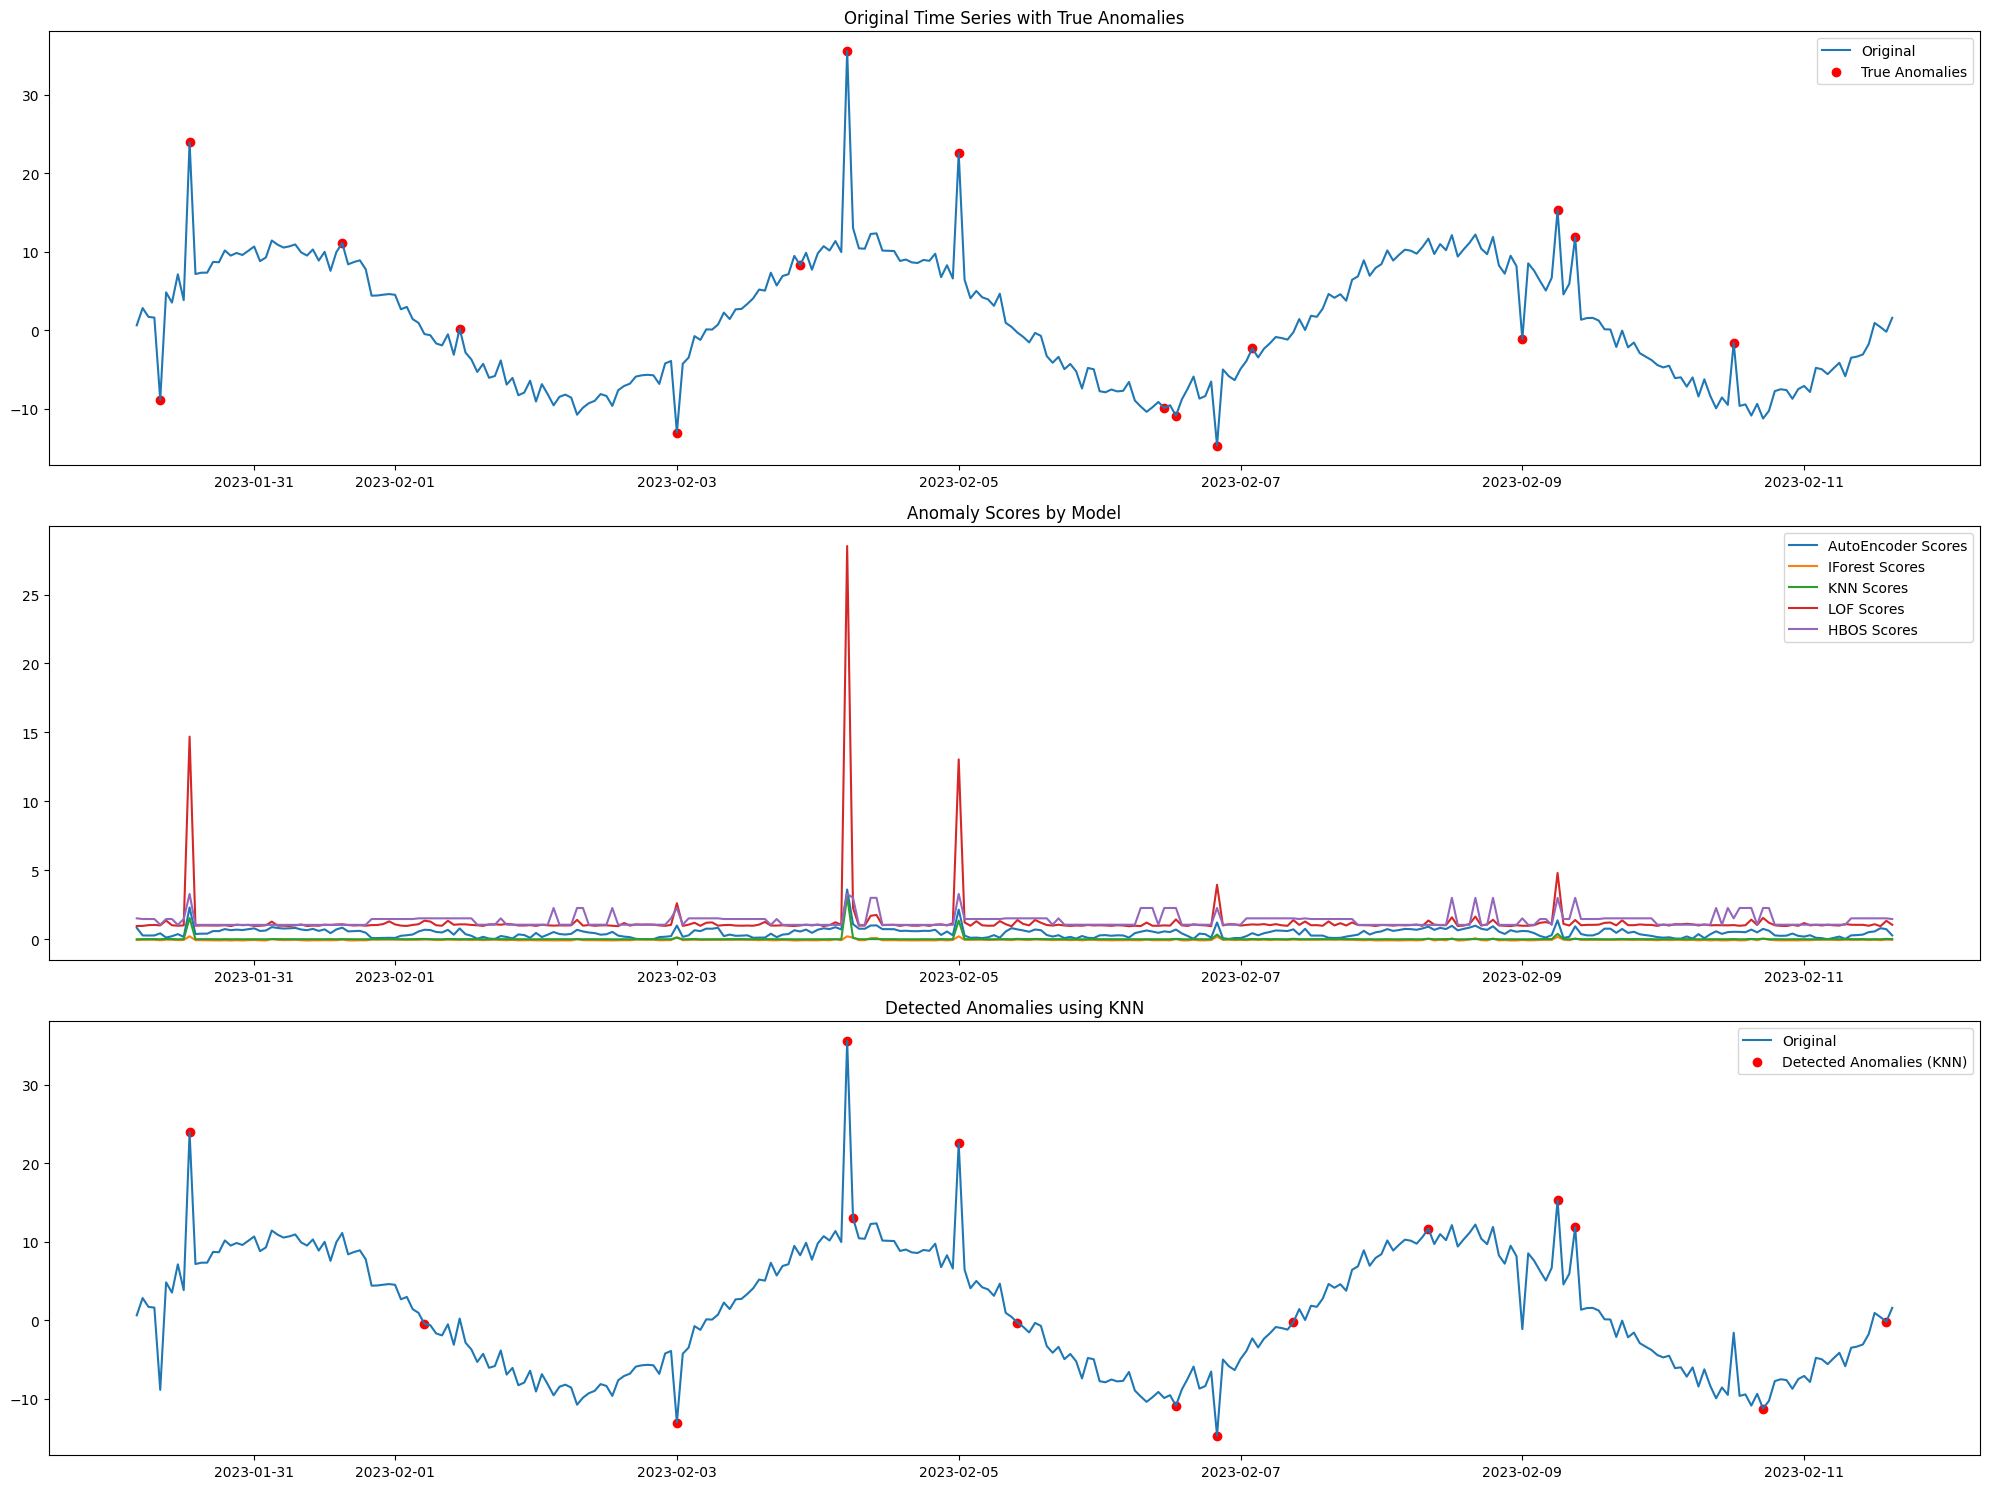

Performance Metrics:
AutoEncoder: Precision = 0.44, Recall = 0.50, F1 = 0.47, AUC = 0.83
IForest: Precision = 0.40, Recall = 0.50, F1 = 0.44, AUC = 0.76
KNN: Precision = 0.54, Recall = 0.44, F1 = 0.48, AUC = 0.75
LOF: Precision = 0.42, Recall = 0.50, F1 = 0.46, AUC = 0.75
HBOS: Precision = 0.45, Recall = 0.31, F1 = 0.37, AUC = 0.80


NameError: name 'ensemble_anomaly_scores' is not defined

In [36]:
# Generate or load your data
data, true_labels = generate_complex_timeseries(n_samples=1000, contamination=0.05)

# Preprocess data
X, scaler = preprocess_data(data)

# Split data
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_true = true_labels[train_size:]

# Define models
models = get_models(contamination=0.05)

# Train and evaluate models
results = train_and_evaluate_models(X_train, X_test, y_true, models)

# Visualize results
visualize_results(data, X_test, y_true, results)

# Print performance metrics
print("Performance Metrics:")
for name, result in results.items():
    print(f"{name}: Precision = {result['precision']:.2f}, Recall = {result['recall']:.2f}, F1 = {result['f1']:.2f}, AUC = {result['auc']:.2f}")

# Evaluate ensemble method
ensemble_scores = ensemble_anomaly_scores(results)
ensemble_predictions = (ensemble_scores > np.percentile(ensemble_scores, 95)).astype(int)
ensemble_precision, ensemble_recall, ensemble_f1, _ = precision_recall_fscore_support(y_true, ensemble_predictions, average='binary')
ensemble_auc = roc_auc_score(y_true, ensemble_scores)

print(f"\nEnsemble Method: Precision = {ensemble_precision:.2f}, Recall = {ensemble_recall:.2f}, F1 = {ensemble_f1:.2f}, AUC = {ensemble_auc:.2f}")

In [33]:
import pyod

print(pyod.__version__)


2.0.2
